In [33]:
from KERNEL import *
from BLUR import *
from GCV import *
from ESF import *
from EVALSIG import *
from TKV_REG import *
from TV_REG import *

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from tqdm.notebook import tqdm

sns.set_palette('colorblind')
sns.set_context("paper")
sns.set_style('white')
#, 'size': 11
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

esffunc = logistic

In [32]:
sig_file = "base_signals.csv"
sigs = open(sig_file, 'r')
smooth = sigs.readline()
sharp = sigs.readline()
sigs.close()

smooth = smooth.split(',')
smooth = [float(i) for i in smooth]
sharp = sharp.split(',')
sharp = [float(i) for i in sharp]

In [34]:
for i in range(512):
    offset = 64
    if i < 64+offset:
        smooth[i] = 0.
    elif 64+offset <= i < 192+offset:
        smooth[i] = 0.5*np.cos(np.pi*(i-offset)/64) + 0.5
    elif 192+offset <= i < 256+offset:
        smooth[i] = 0.2*np.cos(2 * np.pi * (i-offset)  / 64 + np.pi) + 0.2
    elif 256+offset <= i < 342+offset:
        smooth[i] = 0.4*np.cos(1.5 * np.pi * (i-offset)  / 64 + np.pi) + 0.4
    else:
        smooth[i] = 0.

In [35]:
combo = [i for i in range(512)]
for i in range(512):
    if i < 32:
        combo[i] = 0.
    elif i >= 32 and i < 220:
        combo[i] = 1 / (1 + np.exp(-0.1 * (i - 130)))
    elif i >= 220 and i < 230:
        combo[i] = 1.
    elif i >= 230 and i < 270:
        combo[i] = 0.7
    elif i >= 270 and i < 310:
        combo[i] = 0.2
    elif i >= 370 and i < 410:
        combo[i] = 0.6
    else:
        combo[i] = 0.

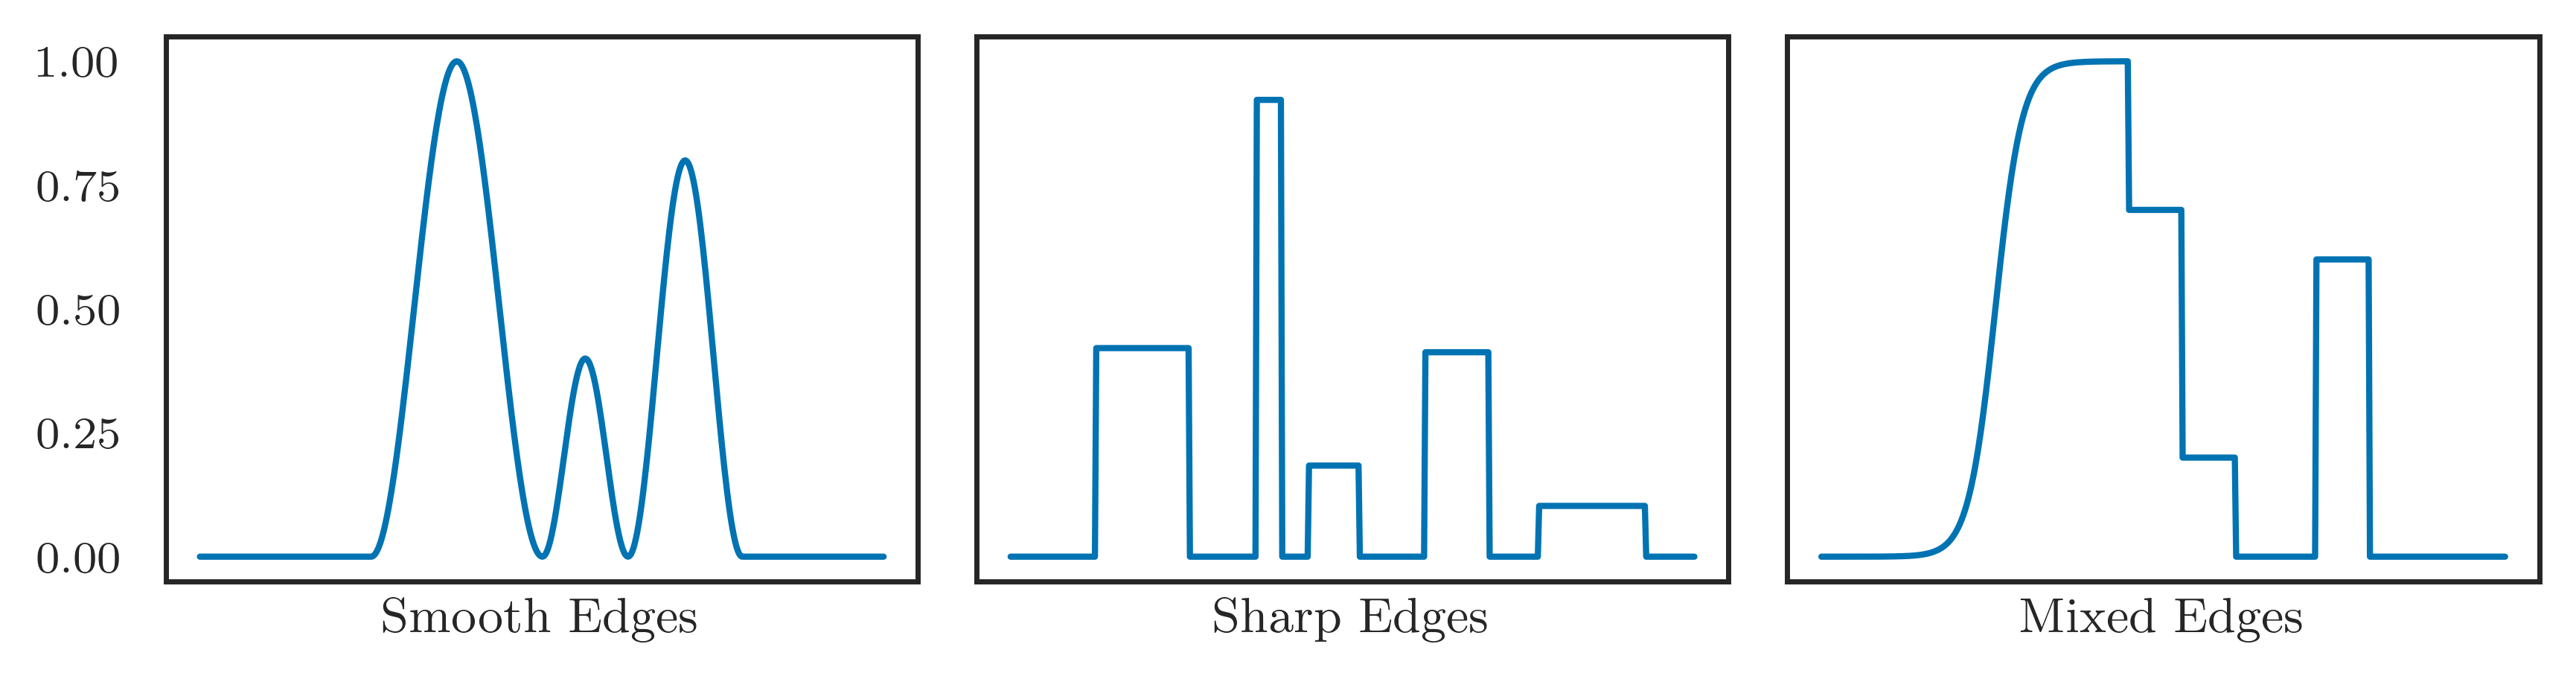

In [36]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, sharey='row')
ax0.plot(smooth)
ax0.grid(False)
ax0.xaxis.set_visible(False)
ax0.set_title('Smooth Edges', y=-0.15)

ax1.plot(sharp)
ax1.grid(False)
ax1.xaxis.set_visible(False)
ax1.set_title('Sharp Edges', y=-0.15)

ax2.plot(combo)
ax2.grid(False)
ax2.xaxis.set_visible(False)
ax2.set_title('Mixed Edges', y=-0.15)

plt.ylim([-0.05, 1.05])
plt.tight_layout()

fig.set_figwidth(7)
fig.set_figheight(1.75)
fig.set_dpi(500)
plt.show()
#plt.savefig('./figures/types.png', dpi=500)

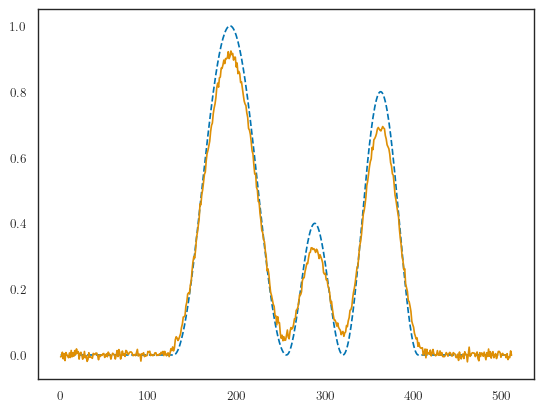

In [37]:
A = kernel(512, 9)
sm_blur = blur(np.asarray(smooth), A, True, 0.008)

plt.plot(smooth, '--')
plt.plot(sm_blur)
plt.grid(False)
plt.show()

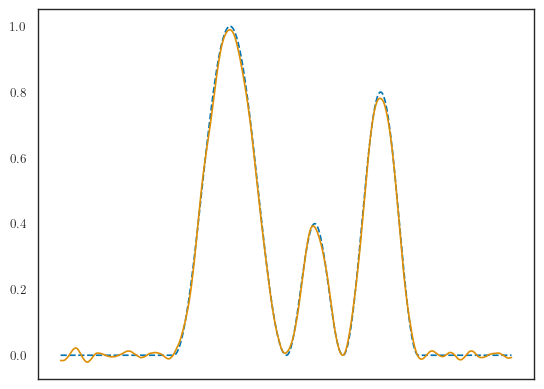

In [38]:
re_sm = tkv_regularize(sm_blur, A, 0.012)

plt.axes().get_xaxis().set_visible(False)
plt.plot(smooth, '--')
plt.plot(re_sm)
plt.grid(False)
plt.show()
#plt.savefig('./figures/tkv.png', dpi=500, transparent=True)

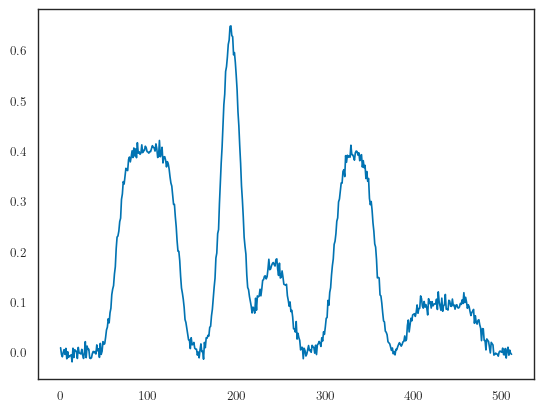

In [39]:
sh_blur = blur(np.asarray(sharp), A, True, 0.008)


plt.plot(sh_blur)
plt.grid(False)
plt.show()

In [40]:
togglePbar(1)
re_sh, gcv = run_gcv(A, np.array(sh_blur).reshape(512,1), tv_regularize, 3)

  0%|          | 0/30 [00:00<?, ?it/s]

3.7356337741416315e-08


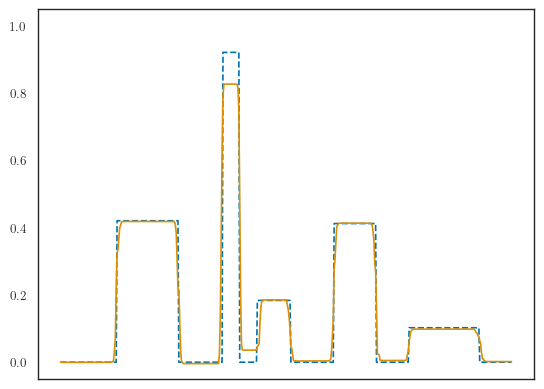

In [41]:
plt.axes().get_xaxis().set_visible(False)
plt.plot(sharp, '--')
plt.plot(re_sh)
plt.grid(False)
plt.ylim([-0.05, 1.05])
#plt.show()
plt.savefig('./figures/tv.png', dpi=500, transparent=True)

print(find_mse(sharp, list(re_sh)[0]))

In [42]:
calib_x = []
for i in range(512):
    if i < 256:
        calib_x.append(0.)
    else:
        calib_x.append(1.)
calib_x = np.asarray(calib_x).reshape(len(calib_x), 1)
calib_A = kernel(calib_x.shape[0], 9)
calib_b = blur(calib_x, calib_A, True, 0.008)

calib_x = calib_x[128:384]
calib_b = calib_b[128:384]

calib_b = normalize_edge(calib_b.transpose()[0])

In [43]:
n = 256
k = [np.random.random() for i in range(n)]
mses = [find_mse(calib_b, esffunc(term, 256)) for term in k]
m = find_index(min(mses), mses)
fit = esffunc(k[m], 256)

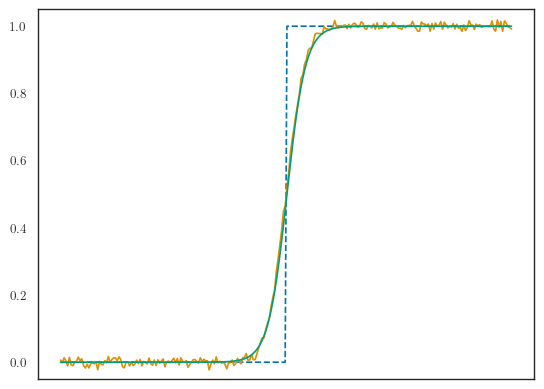

In [44]:
plt.axes().get_xaxis().set_visible(False)
plt.plot(calib_x, '--')
plt.plot(calib_b)
plt.plot(fit)
plt.ylim([-0.05, 1.05])
#plt.show()
plt.savefig('./figures/ESF.png', dpi=500, transparent=True)

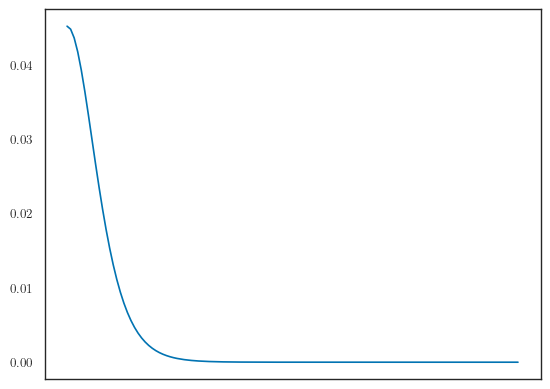

In [45]:
plt.axes().get_xaxis().set_visible(False)
dc = diff(esffunc(k[m], 256), 256)
dc = normalize_diff(dc[len(calib_b)//2:])
plt.plot(dc)
#plt.show()
plt.savefig('./figures/LSF.png', dpi=500, transparent=True)

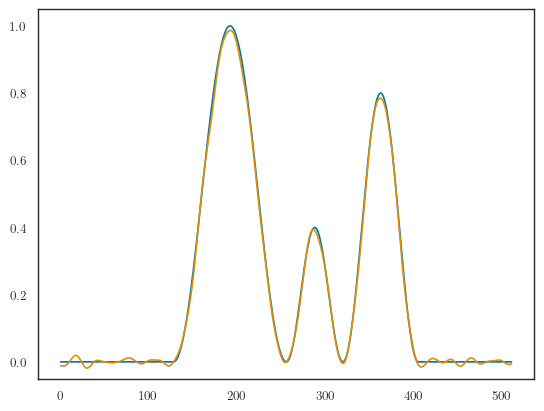

9.737908058120668e-05


In [46]:
A = generateBlurMatrix(512, dc)
re_sm = tkv_regularize(sm_blur, A, 0.02)
plt.plot(smooth)
plt.plot(re_sm)
plt.ylim([-0.05, 1.05])
plt.show()

print(find_mse(smooth, re_sm))

In [ ]:
re_sh, gcv = run_gcv(A, np.array(sh_blur).reshape(512,1), tv_regularize, 2)

In [47]:
re_sh = tv_regularize(np.array(sh_blur).reshape(512,1), A, 0.005)

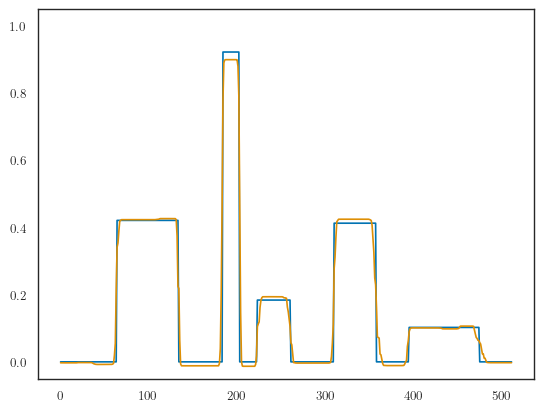

In [48]:
plt.plot(sharp)
plt.plot(re_sh)
plt.ylim([-0.05, 1.05])
plt.show()

In [49]:
qualifiedBlur = []
#mmse = 2. * min(mses)
threshold = min(mses) * 1.05
for i in range(len(mses)):
    if mses[i] <= threshold:
        qualifiedBlur.append([mses[i], k[i]])

In [50]:
plots = []
for i in qualifiedBlur:
    fit = use_erf(i[1], len(sm_blur))
    diffFit = diff(fit, len(sm_blur))
    diffFit = normalize_diff(diffFit[len(sm_blur)//2:])
    A = generateBlurMatrix(len(sm_blur), diffFit)
    #out, err = run_gcv(A, sm_blur, tkv_regularize, 8)
    out = tkv_regularize(sm_blur, A, 0.012)
    plots.append(out)

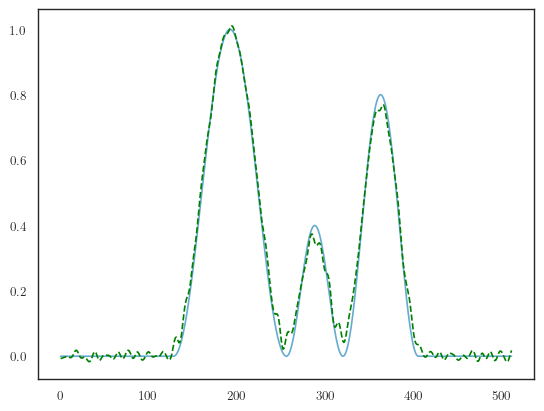

In [51]:
plt.plot(smooth, alpha=0.6)
for p in plots:
    plt.plot(p, 'g--')
plt.show()

In [52]:
lineout = []
with open('edges.csv','r') as csv:
    for i in csv.readlines():
        lineout.append(float(i))
    csv.close()
        
ca = open('ESF.csv', 'r')
calibrator = [float(i) for i in ca.readline().split(',')]
ca.close()

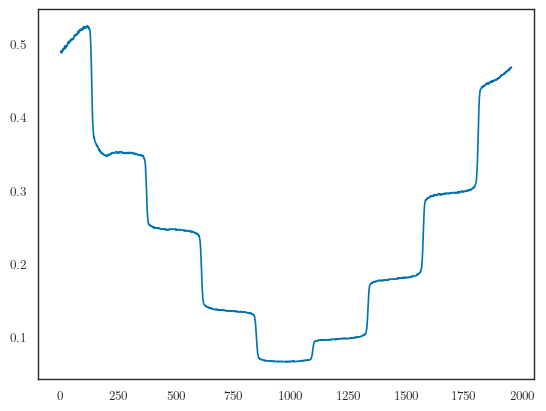

In [53]:
plt.plot(lineout)
plt.show()
#plt.savefig('./figures/lineout.png', dpi=500, transparent=True)

In [60]:
calib_b = normalize_edge(normalize_edge(calibrator))
n = 1024
k = [np.random.random() for i in range(n)]
mses = [find_mse(calib_b, esffunc(term, 501)) for term in k]
m = find_index(min(mses), mses)
fit = esffunc(k[m], 501)

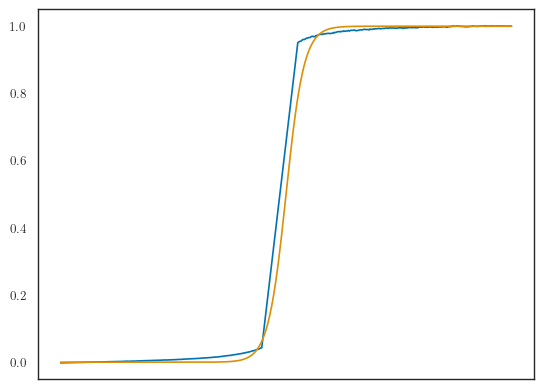

In [61]:
plt.axes().get_xaxis().set_visible(False)
plt.plot(calib_b)
plt.plot(fit)
plt.ylim([-0.05, 1.05])
plt.show()

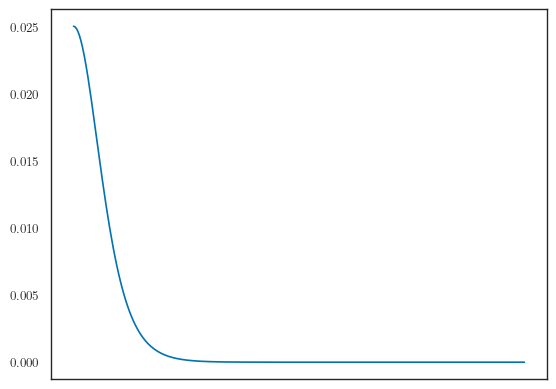

In [59]:
plt.axes().get_xaxis().set_visible(False)
dc = diff(esffunc(k[m], 501), 501)
dc = normalize_diff(dc[len(calib_b)//2:])
plt.plot(dc)
plt.show()

A = generateBlurMatrix(501, dc)

In [57]:
out, err = run_gcv(A, np.array(calibrator).reshape(501,1), tv_regularize, 2)

  0%|          | 0/20 [00:00<?, ?it/s]

In [0]:
plt.plot(calibrator, '--')
plt.plot(out)
plt.show()

In [72]:
A = generateBlurMatrix(len(lineout), dc)
out = run_gcv(A, np.array(lineout).reshape(len(lineout), 1), tv_regularize, 3)

  0%|          | 0/30 [00:00<?, ?it/s]

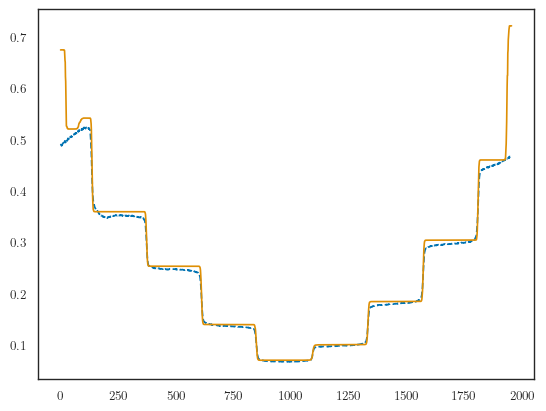

In [74]:
plt.plot(lineout, '--')
plt.plot(out[0])
plt.show()